# New York City Flood Zone EDA

# 1. Introduction

I've wanted to do this project for some time now, and I'm finally happy to share this open source project.

This notebook demonstrates how to analyze FEMA's Preliminary Flood Insurance Rate Map (i.e. PFIRM), sometimes known as '*flood zone*.' The flood zone is for New York City (all five boroughs).

Let's see what cool things we can discover about this dataset!

# Libraries

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import urllib.request
from zipfile import ZipFile

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [99]:
# # url path from the web
# url = 'https://msc.fema.gov/portal/downloadProduct?productID=360497_PRELIMDB'
# print('data url path:', url)

# # assigning file name as 'pfirm_nyc.zip'
# urllib.request.urlretrieve(url, 'pfirm_nyc.zip')

# listing files in our directory
print('listing the new downloaded file in our directory:')
%ls

listing the new downloaded file in our directory:
README.md                       pfirm_nyc/
floodzone_pfirm_analysis.ipynb  pfirm_nyc.zip


In [100]:
# path = 'pfirm_nyc.zip'
# print('name of zip file:', path)

# # opening zip using 'with' keyword in read mode
# with zipfile.ZipFile(path, 'r') as file:
#     # extracing all items in our zipfile
#     # naming our file 'pfirm_nyc'
#     file.extractall('pfirm_nyc')

print('listing items after unzipping the file:\n')
%ls pfirm_nyc/    

listing items after unzipping the file:

360497_PRELIM_metadata.txt  s_fld_haz_ar.shx
360497_PRELIM_metadata.xml  s_fld_haz_ln.dbf
L_PAN_REVIS.dbf             s_fld_haz_ln.shp
L_POL_FHBM.dbf              s_fld_haz_ln.shx
S_BASE_INDEX.prj            s_gen_struct.dbf
S_BFE.prj                   s_gen_struct.shp
S_CBRS.prj                  s_gen_struct.shx
S_CST_TSCT_LN.dbf           s_label_ld.dbf
S_CST_TSCT_LN.prj           s_label_ld.prj
S_CST_TSCT_LN.shp           s_label_ld.sbn
S_CST_TSCT_LN.shx           s_label_ld.sbx
S_FIRM_PAN.prj              s_label_ld.shp
S_FLD_HAZ_AR.prj            s_label_ld.shx
S_FLD_HAZ_LN.prj            s_label_pt.dbf
S_GEN_STRUCT.prj            s_label_pt.prj
S_LiMWA.dbf                 s_label_pt.sbn
S_LiMWA.prj                 s_label_pt.sbx
S_LiMWA.shp                 s_label_pt.shp
S_LiMWA.shx                 s_label_pt.shx
S_PERM_BMK.prj              s_perm_bmk.dbf
S_POL_AR.prj                s_perm_bmk.shp
S_POL_LN.prj                s_perm_bmk.shx

# 2. The files

For this analysis, we are interested in the special flood hazard area shapefile - `s_fld_haz_area.shp`. This contains information about the flood zone. A shapefile is geospatial vector data for geographic information system software and stores geometric location and associated attribute information.

## 2.1 Inspecting the data

In [101]:
# reading in shape file
path = 'pfirm_nyc/s_fld_haz_ar.shp'
pfirm_df = gpd.read_file(path)

# previewing first five rorws of data
pfirm_df.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [102]:
# previewing last five rorws of data
pfirm_df.tail()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
3980,4061,AE,FLOODWAY,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((948012.835 151530.411, 948018.441 15..."
3981,4062,AE,None,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((1019981.024 235220.224, 1019960.066 ..."
3982,4063,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1019888.296 235113.767, 1019910.519 ..."
3983,4064,AE,None,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((1020681.583 235274.734, 1020618.617 ..."
3984,4065,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1020681.583 235274.734, 1020700.681 ..."


In [103]:
print('dataframe shape\n')

rows = pfirm_df.shape[0]
columns = pfirm_df.shape[1]

print('number of rows: {:,}.\nnumber of columns: {}.'.format(rows, columns))

dataframe shape

number of rows: 3,985.
number of columns: 15.


In [104]:
print('type of python object:\n\n{}'.format(type(pfirm_df)))

type of python object:

<class 'geopandas.geodataframe.GeoDataFrame'>


a rough plot of our geometry.


<AxesSubplot:>

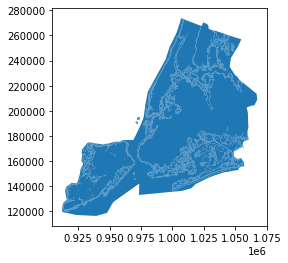

In [105]:
print('a rough plot of our geometry.')
pfirm_df.plot()

In [106]:
# summary of the data
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3985 non-null   object  
 1   FLD_ZONE    3985 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3985 non-null   object  
 4   STATIC_BFE  3985 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       3985 non-null   float64 
 7   LEN_UNIT    1165 non-null   object  
 8   VELOCITY    3985 non-null   float64 
 9   VEL_UNIT    0 non-null      object  
 10  AR_REVERT   0 non-null      object  
 11  BFE_REVERT  3985 non-null   float64 
 12  DEP_REVERT  3985 non-null   float64 
 13  SOURCE_CIT  3985 non-null   object  
 14  geometry    3985 non-null   geometry
dtypes: float64(5), geometry(1), object(9)
memory usage: 467.1+ KB


In [107]:
print('count of data types:')
pfirm_df.dtypes.value_counts()

count of data types:


object      9
float64     5
geometry    1
dtype: int64

In [108]:
print('summary statistics for numeric columns')
pfirm_df.describe()

summary statistics for numeric columns


,STATIC_BFE,DEPTH,VELOCITY,BFE_REVERT,DEP_REVERT
count,3985.000000,3985.000000,3985.0,3985.0,3985.0
mean,-7101.950314,-9968.883061,-9999.0,-9999.0,-9999.0
std,4540.905248,548.067414,0.0,0.0,0.0
min,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
25%,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
50%,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
75%,11.000000,-9999.000000,-9999.0,-9999.0,-9999.0
max,34.000000,3.000000,-9999.0,-9999.0,-9999.0


In [109]:
print('summary statistics for string columns')
pfirm_df.describe(include='object')

summary statistics for string columns


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,V_DATUM,LEN_UNIT,VEL_UNIT,AR_REVERT,SOURCE_CIT
count,3985,3985,47,3985,1153,1165,0,0,3985
unique,3985,7,1,2,1,1,0,0,3
top,882,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,FLOODWAY,F,NAVD88,FEET,NaN,NaN,STUDY4
freq,1,1726,47,2263,1153,1165,NaN,NaN,2937


In [110]:
print('summary statistics for all column types')
pfirm_df.drop(columns='geometry').describe(include='all').T

summary statistics for all column types


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FLD_AR_ID,3985,3985,882,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLD_ZONE,3985,7,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLOODWAY,47,1,FLOODWAY,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SFHA_TF,3985,2,F,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATIC_BFE,3985.0,NaN,NaN,NaN,-7101.950314,4540.905248,-9999.0,-9999.0,-9999.0,11.0,34.0
V_DATUM,1153,1,NAVD88,1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEPTH,3985.0,NaN,NaN,NaN,-9968.883061,548.067414,-9999.0,-9999.0,-9999.0,-9999.0,3.0
LEN_UNIT,1165,1,FEET,1165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VELOCITY,3985.0,NaN,NaN,NaN,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
VEL_UNIT,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics of each column:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics of each column:


,count_null,normalized
VEL_UNIT,3985,1.000
AR_REVERT,3985,1.000
FLOODWAY,3938,0.988
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
STATIC_BFE,0,0.000
DEPTH,0,0.000


In [112]:
print('total number of nulls in data: {:,}.'.format(pfirm_df.isnull().sum().sum()))

total number of nulls in data: 17,560.


## 2.2 Dropping unnecessary columns

In [113]:
# previewing columns that are 100% null
pfirm_df[['VEL_UNIT', 'AR_REVERT']].head()

,VEL_UNIT,AR_REVERT
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None


In [114]:
print('number of columns: {}'.format(pfirm_df.shape[1]))

# dropping 100% null columns
pfirm_df = pfirm_df.drop(columns=['VEL_UNIT', 'AR_REVERT'])
print('new number of columns: {}\n'.format(pfirm_df.shape[1]))

pfirm_df.head()

number of columns: 15
new number of columns: 13



,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [115]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 2)

print('null statistics:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics:


,count_null,normalized
FLOODWAY,3938,0.99
V_DATUM,2832,0.71
LEN_UNIT,2820,0.71
FLD_AR_ID,0,0.00
FLD_ZONE,0,0.00
SFHA_TF,0,0.00
STATIC_BFE,0,0.00
DEPTH,0,0.00
VELOCITY,0,0.00
BFE_REVERT,0,0.00


In [116]:
print('reviewing items in FLOODWAY column that is almost 100% null')
pfirm_df['FLOODWAY'].value_counts(dropna=False)

reviewing items in FLOODWAY column that is almost 100% null


NaN         3938
FLOODWAY      47
Name: FLOODWAY, dtype: int64

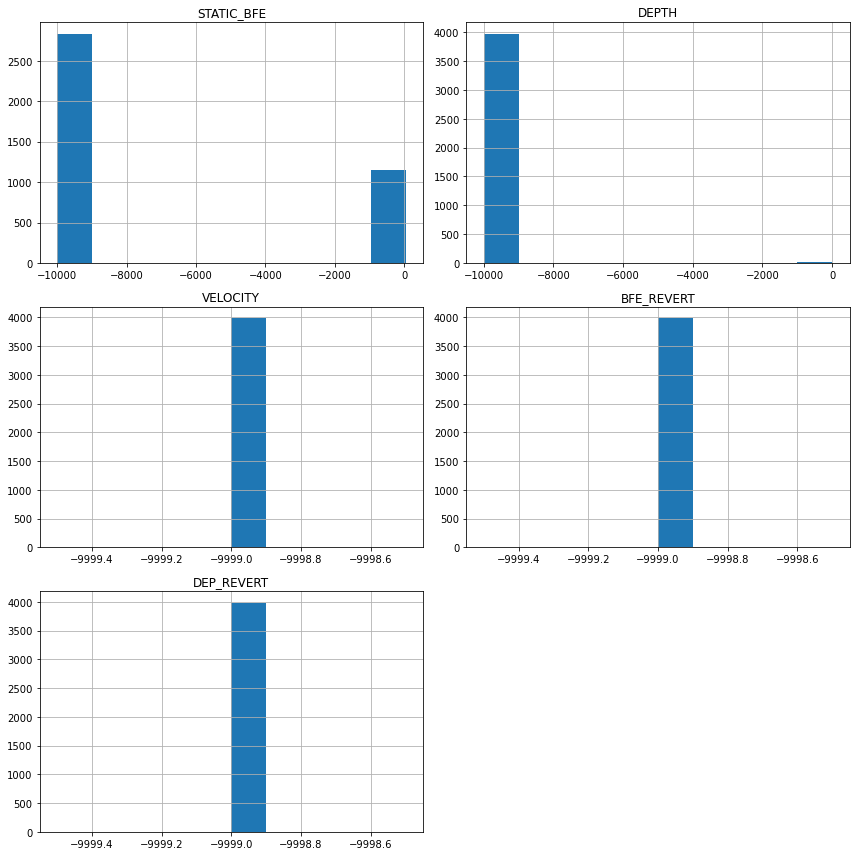

In [117]:
# plotting histograms of numeric columns
pfirm_df.hist(figsize=(12,12))
plt.tight_layout()

In [118]:
print('previewing items within each column.')
print("hopefully we'll find columns that are not null but are still not useful for this analysis.\n")

for col in pfirm_df.columns:
    # geometry type does not have a .value_counts() method
    if col == 'geometry':
        continue
    print(col, 'value counts:')    
    print(pfirm_df[col].value_counts(dropna=False, normalize=True).head())
    print()

previewing items within each column.
hopefully we'll find columns that are not null but are still not useful for this analysis.

FLD_AR_ID value counts:
882     0.000251
598     0.000251
1419    0.000251
3721    0.000251
846     0.000251
Name: FLD_AR_ID, dtype: float64

FLD_ZONE value counts:
0.2 PCT ANNUAL CHANCE FLOOD HAZARD    0.433124
AE                                    0.318444
X                                     0.132748
VE                                    0.105395
A                                     0.005270
Name: FLD_ZONE, dtype: float64

FLOODWAY value counts:
NaN         0.988206
FLOODWAY    0.011794
Name: FLOODWAY, dtype: float64

SFHA_TF value counts:
F    0.56788
T    0.43212
Name: SFHA_TF, dtype: float64

STATIC_BFE value counts:
-9999.0    0.710665
 13.0      0.055458
 14.0      0.038896
 11.0      0.036888
 12.0      0.036136
Name: STATIC_BFE, dtype: float64

V_DATUM value counts:
NaN       0.710665
NAVD88    0.289335
Name: V_DATUM, dtype: float64

DEPTH value c

In [119]:
print('reviewing possible columns to drop.\n')

print('after reviewing items within each column, there are a few columns\nthat have only one value as well as \
values that look off (e.g. -9999.0.)\n')

print("let's continue to inspect these columns.")

pfirm_df.iloc[:, -5:-1].head()

reviewing possible columns to drop.

after reviewing items within each column, there are a few columns
that have only one value as well as values that look off (e.g. -9999.0.)

let's continue to inspect these columns.


,VELOCITY,BFE_REVERT,DEP_REVERT,SOURCE_CIT
0,-9999.0,-9999.0,-9999.0,STUDY4
1,-9999.0,-9999.0,-9999.0,STUDY4
2,-9999.0,-9999.0,-9999.0,STUDY4
3,-9999.0,-9999.0,-9999.0,STUDY4
4,-9999.0,-9999.0,-9999.0,STUDY4


In [120]:
print("these columns appear to be not useful in this analysis, so I'll drop them.")

these columns appear to be not useful in this analysis, so I'll drop them.


In [121]:
print('number of columns: {}'.format(pfirm_df.shape[1]))

col_drop = pfirm_df.iloc[:, -5:-1].columns
print('columns to drop:', col_drop.to_list())

pfirm_df = pfirm_df.drop(columns=col_drop)
print('number of new columns: {}'.format(pfirm_df.shape[1]))

pfirm_df.head()

number of columns: 13
columns to drop: ['VELOCITY', 'BFE_REVERT', 'DEP_REVERT', 'SOURCE_CIT']
number of new columns: 9


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [122]:
# inspecting our data
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3985 non-null   object  
 1   FLD_ZONE    3985 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3985 non-null   object  
 4   STATIC_BFE  3985 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       3985 non-null   float64 
 7   LEN_UNIT    1165 non-null   object  
 8   geometry    3985 non-null   geometry
dtypes: float64(2), geometry(1), object(6)
memory usage: 280.3+ KB


In [123]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 2)

print('null statistics:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics:


,count_null,normalized
FLOODWAY,3938,0.99
V_DATUM,2832,0.71
LEN_UNIT,2820,0.71
FLD_AR_ID,0,0.00
FLD_ZONE,0,0.00
SFHA_TF,0,0.00
STATIC_BFE,0,0.00
DEPTH,0,0.00
geometry,0,0.00


## 2.3 Inspecting our geometry column

In [124]:
print("lastly, let's inspect our geometry column, which is a type provided by the shapefile (.shp) format.\n")

print('reviewing geometry column:')
pfirm_df[['geometry']].head()

lastly, let's inspect our geometry column, which is a type provided by the shapefile (.shp) format.

reviewing geometry column:


,geometry
0,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [125]:
pfirm_df[['geometry']].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  3985 non-null   geometry
dtypes: geometry(1)
memory usage: 31.3 KB


In [126]:
print("reviewing the geometry's coordinate referance system (CRS).")
pfirm_df.crs

reviewing the geometry's coordinate referance system (CRS).


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# 3. Inspecting flood zones and static base flood elevation values

In [127]:
print('reviewing items in the FLD_ZONE column:')
pfirm_df['FLD_ZONE'].value_counts()

reviewing items in the FLD_ZONE column:


0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
X                                      529
VE                                     420
A                                       21
AO                                      12
OPEN WATER                               8
Name: FLD_ZONE, dtype: int64

In [128]:
print('reviewing summary statistics for base flood elevations by flood zone:')
pfirm_df.groupby(by=['FLD_ZONE'])['STATIC_BFE'].describe()

reviewing summary statistics for base flood elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
A,21.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
AE,1269.0,-4216.189125,4946.985064,-9999.0,-9999.0,10.0,13.0,23.0
AO,12.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
OPEN WATER,8.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
VE,420.0,16.133333,3.126045,11.0,14.0,16.0,17.0,34.0
X,529.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [129]:
print('reviewing summary statistics for depth elevations by flood zone:')
pfirm_df.groupby(by=['FLD_ZONE'])['DEPTH'].describe()

reviewing summary statistics for depth elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
A,21.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
AE,1269.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
AO,12.0,2.333333,0.887625,1.0,1.75,3.0,3.0,3.0
OPEN WATER,8.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
VE,420.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
X,529.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0


## 3.1 Replacing -9999 values with null

In [130]:
print("it seems to be that this dataset represents null values for certain numeric columns as -9999.0.\n\
let's see what the values are if we exclude these values.")

pfirm_df.loc[pfirm_df['STATIC_BFE'] > -9999][['STATIC_BFE']].describe()

it seems to be that this dataset represents null values for certain numeric columns as -9999.0.
let's see what the values are if we exclude these values.


,STATIC_BFE
count,1153.000000
mean,13.786644
std,2.996455
min,8.000000
25%,12.000000
50%,13.000000
75%,15.000000
max,34.000000


In [134]:
print("those values look much better and are probably the real statistics of our\
static base flood elevation column.\n")

print('for this analysis, we can safely replace the -9999.0 values with nulls.\n')

print("let's first track our replacement process.")

those values look much better and are probably the real statistics of ourstatic base flood elevation column.

for this analysis, we can safely replace the -9999.0 values with nulls.

let's first track our replacement process.


In [138]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics:')
print('total nulls in dataframe: {:,}.'.format(s1.sum()))
before_replace_df = pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)
before_replace_df

null statistics:
total nulls in dataframe: 9,590.


,count_null,normalized
FLOODWAY,3938,0.988
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
STATIC_BFE,0,0.000
DEPTH,0,0.000
geometry,0,0.000


In [139]:
print('replacing incorrectly inserted values (e.g. -9999) with nans.')

for col in ['STATIC_BFE', 'DEPTH']:
    
    # if our column value is less than -1, replace with nan, else keep column value
    pfirm_df[col] = np.where(pfirm_df[col] < -1, np.nan, pfirm_df[col])
    
pfirm_df.describe()    

replacing incorrectly inserted values (e.g. -9999) with nans.


,STATIC_BFE,DEPTH
count,1153.000000,12.000000
mean,13.786644,2.333333
std,2.996455,0.887625
min,8.000000,1.000000
25%,12.000000,1.750000
50%,13.000000,3.000000
75%,15.000000,3.000000
max,34.000000,3.000000


In [140]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics:')
print('total nulls in dataframe: {:,}.'.format(s1.sum()))
after_replace_df = pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)
after_replace_df

null statistics:
total nulls in dataframe: 16,395.


,count_null,normalized
DEPTH,3973,0.997
FLOODWAY,3938,0.988
STATIC_BFE,2832,0.711
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
geometry,0,0.000


In [146]:
pd.concat([before_replace_df, 
           after_replace_df.rename(columns={'count_null':'count_after', 
                                            'normalized':'normalized_after'})], axis=1)

,count_null,normalized,count_after,normalized_after
FLOODWAY,3938,0.988,3938,0.988
V_DATUM,2832,0.711,2832,0.711
LEN_UNIT,2820,0.708,2820,0.708
FLD_AR_ID,0,0.000,0,0.000
FLD_ZONE,0,0.000,0,0.000
SFHA_TF,0,0.000,0,0.000
STATIC_BFE,0,0.000,2832,0.711
DEPTH,0,0.000,3973,0.997
geometry,0,0.000,0,0.000


In [150]:
print('you can see that both columns static_bfe and depth have a significant amount\nof null values\
 after replacing -9999 with null.')

you can see that both columns static_bfe and depth have a significant amount
of null values after replacing -9999 with null.


In [151]:
print('reviewing summary statistics for static base flood elevations by flood zone:')

pfirm_df.groupby(by=['FLD_ZONE'])['STATIC_BFE'].describe()

reviewing summary statistics for static base flood elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE,733.0,12.442019,1.888557,8.0,11.0,12.0,14.0,23.0
AO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPEN WATER,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VE,420.0,16.133333,3.126045,11.0,14.0,16.0,17.0,34.0
X,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
print('reviewing summary statistics for depths by flood zone:')

pfirm_df.groupby(by=['FLD_ZONE'])['DEPTH'].describe()

reviewing summary statistics for depths by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AO,12.0,2.333333,0.887625,1.0,1.75,3.0,3.0,3.0
OPEN WATER,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


distribution of numeric columns.
this is perhaps the true distribution of these columns:


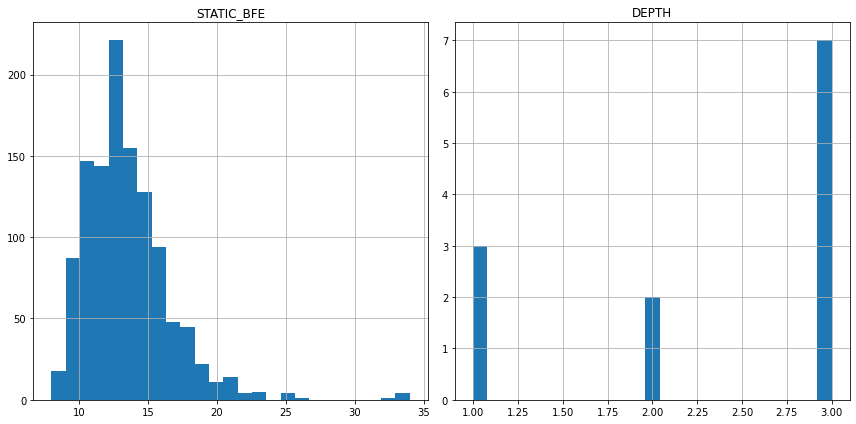

In [153]:
print('distribution of numeric columns.')
print('this is perhaps the true distribution of these columns:')

pfirm_df.hist(figsize=(12,6), bins=25)
plt.tight_layout()

## 3.2 Dropping unnecessary flood zone values

In [200]:
pfirm_df['FLD_ZONE'].value_counts()

0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
X                                      529
VE                                     420
A                                       21
AO                                      12
OPEN WATER                               8
Name: FLD_ZONE, dtype: int64

In [201]:
pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])].head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
1,82,X,None,F,NaN,None,NaN,None,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
6,87,X,None,F,NaN,None,NaN,None,"POLYGON ((1034013.168 257011.473, 1034007.732 ..."
11,92,X,None,F,NaN,None,NaN,None,"POLYGON ((1043995.696 257160.314, 1043996.904 ..."
15,96,X,None,F,NaN,None,NaN,None,"POLYGON ((1034329.553 253484.038, 1034317.702 ..."
19,100,X,None,F,NaN,None,NaN,None,"POLYGON ((1029438.728 251094.008, 1029442.937 ..."


In [202]:
pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])].iloc[:, :-1].describe(include='all')

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT
count,537,537,0,537,0.0,0,0.0,0
unique,537,2,0,1,NaN,0,NaN,0
top,3461,X,NaN,F,NaN,NaN,NaN,NaN
freq,1,529,NaN,537,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
d1 = pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])]

d1.groupby(by=['FLD_ZONE', 'SFHA_TF']).count()

,,FLD_AR_ID,FLOODWAY,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
FLD_ZONE,SFHA_TF,,,,,,,
OPEN WATER,F,8,0,0,0,0,0,8
X,F,529,0,0,0,0,0,529


In [204]:
pfirm_df = pfirm_df.loc[~pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])]

pfirm_df.groupby(by=['SFHA_TF', 'FLD_ZONE']).count()

FLD_AR_ID  FLOODWAY  STATIC_BFE  \
SFHA_TF FLD_ZONE                                                              
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD       1726         0           0   
T       A                                          21         0           0   
        AE                                       1269        47         733   
        AO                                         12         0           0   
        VE                                        420         0         420   

                                            V_DATUM  DEPTH  LEN_UNIT  geometry  
SFHA_TF FLD_ZONE                                                                
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD        0      0         0      1726  
T       A                                         0      0         0        21  
        AE                                      733      0       733      1269  
        AO                                        0     12        12        12  
        VE                                      420      0       420       420

In [205]:
pfirm_df['FLD_ZONE'].value_counts()

0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
VE                                     420
A                                       21
AO                                      12
Name: FLD_ZONE, dtype: int64

<AxesSubplot:>

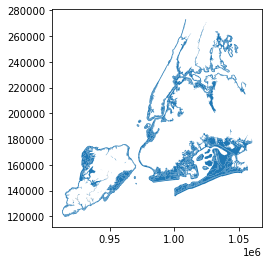

In [206]:
pfirm_df.plot()

In [207]:
pfirm_df.shape

(3448, 9)

In [208]:
pfirm_df.iloc[:, :-1].describe(include='all')

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT
count,3448,3448,47,3448,1153.000000,1153,12.000000,1165
unique,3448,5,1,2,NaN,1,NaN,1
top,3777,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,FLOODWAY,F,NaN,NAVD88,NaN,FEET
freq,1,1726,47,1726,NaN,1153,NaN,1165
mean,NaN,NaN,NaN,NaN,13.786644,NaN,2.333333,NaN
std,NaN,NaN,NaN,NaN,2.996455,NaN,0.887625,NaN
min,NaN,NaN,NaN,NaN,8.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,12.000000,NaN,1.750000,NaN
50%,NaN,NaN,NaN,NaN,13.000000,NaN,3.000000,NaN
75%,NaN,NaN,NaN,NaN,15.000000,NaN,3.000000,NaN


In [209]:
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3448 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3448 non-null   object  
 1   FLD_ZONE    3448 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3448 non-null   object  
 4   STATIC_BFE  1153 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       12 non-null     float64 
 7   LEN_UNIT    1165 non-null   object  
 8   geometry    3448 non-null   geometry
dtypes: float64(2), geometry(1), object(6)
memory usage: 269.4+ KB


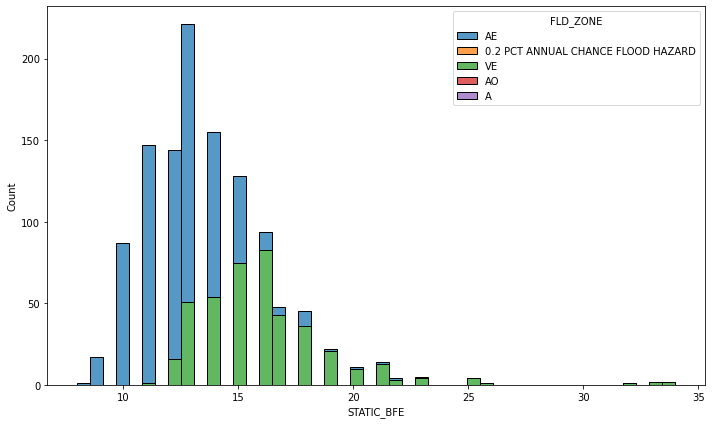

In [210]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(pfirm_df, 
             x='STATIC_BFE', 
             hue='FLD_ZONE', 
             multiple="stack")

plt.tight_layout()

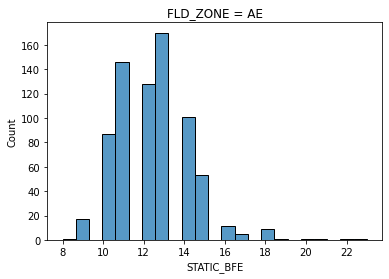

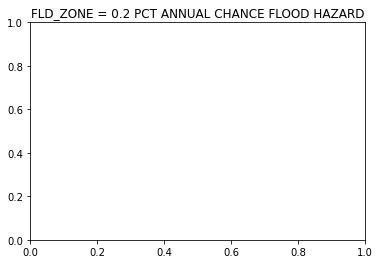

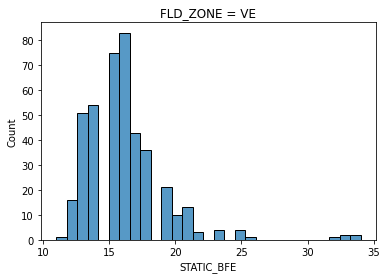

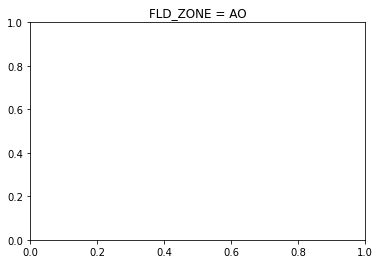

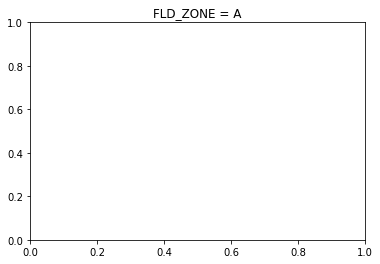

In [211]:
zones = pfirm_df['FLD_ZONE'].unique()

for zone in zones:
    plt.figure()
    plot = pfirm_df.loc[pfirm_df['FLD_ZONE'] == zone]
    
    sns.histplot(plot, x='STATIC_BFE')
    plt.title('FLD_ZONE = {}'.format(zone))

In [212]:
pfirm_df['SFHA_TF'].value_counts()

F    1726
T    1722
Name: SFHA_TF, dtype: int64

In [213]:
pfirm_df.groupby(by=['SFHA_TF'])['STATIC_BFE'].describe()

,count,mean,std,min,25%,50%,75%,max
SFHA_TF,,,,,,,,
F,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,1153.0,13.786644,2.996455,8.0,12.0,13.0,15.0,34.0


<AxesSubplot:>

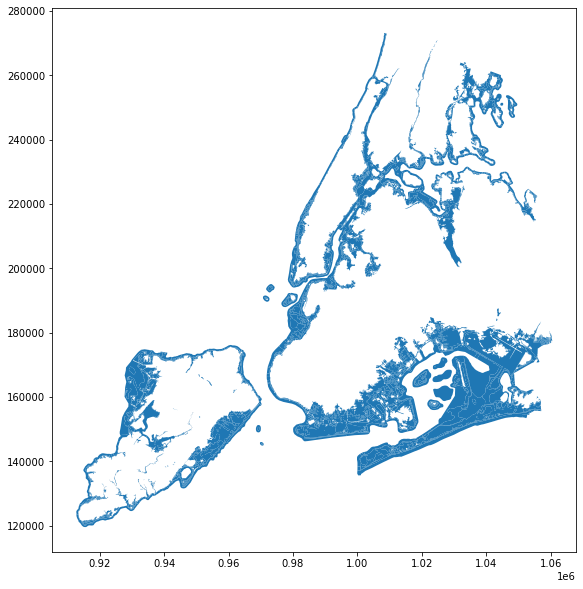

In [214]:
fig, ax = plt.subplots(figsize=(10, 10))

pfirm_df.plot(ax=ax)

In [215]:
pfirm_df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [216]:
pfirm_df['wgs84'] = pfirm_df.to_crs(epsg=4326)['geometry']

pfirm_df.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry,wgs84
0,81,AE,None,T,13.0,NAVD88,NaN,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ...","POLYGON ((-73.82729 40.89080, -73.82728 40.890..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ...","POLYGON ((-73.82256 40.88991, -73.82252 40.889..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ...","POLYGON ((-73.82219 40.88747, -73.82219 40.887..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ...","POLYGON ((-73.81975 40.88694, -73.81975 40.886..."
5,86,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033316.808 262437.816, 1033316.108 ...","POLYGON ((-73.82255 40.88687, -73.82255 40.886..."


In [217]:
pfirm_df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

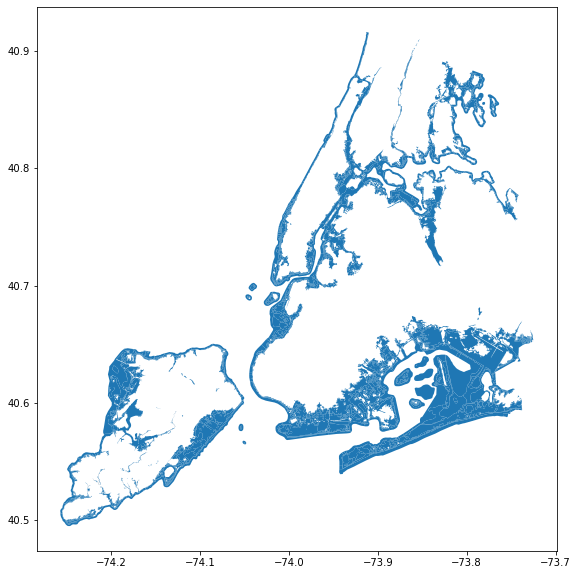

In [218]:
fig, ax = plt.subplots(figsize=(10, 10))

pfirm_df.set_geometry('wgs84').plot(ax=ax)

In [219]:
pfirm_df.area.head()

0    1.414248e+07
2    1.004589e+05
3    1.935660e+05
4    6.573445e+04
5    1.275814e+05
dtype: float64

In [220]:
print('flood zone area statistics:\n')
print('area in feet: {:,.2f}.'.format(pfirm_df.area.sum()))
print('area in miles: {:,.2f}.'.format(pfirm_df.area.sum() / 5280))
print('area in acres: {:,.2f}.'.format(pfirm_df.area.sum() / 43560))

flood zone area statistics:

area in feet: 2,805,616,808.30.
area in miles: 531,366.82.
area in acres: 64,408.10.


In [221]:
pfirm_df.area.describe()

count    3.448000e+03
mean     8.136940e+05
std      4.331836e+06
min      7.270448e-04
25%      9.590391e+03
50%      5.815523e+04
75%      2.886741e+05
max      1.307856e+08
dtype: float64

In [222]:
zones = pfirm_df['FLD_ZONE'].unique()
empty_dict = {}

for zone in zones:
    zone_df = pfirm_df.loc[pfirm_df['FLD_ZONE'] == zone]
    zone_series = zone_df.area.sum() / 5280
    
    empty_dict.update({zone:zone_series})
    
empty_dict 

{'AE': 248946.3399187009,
 '0.2 PCT ANNUAL CHANCE FLOOD HAZARD': 105022.7964686296,
 'VE': 176171.11364276084,
 'AO': 188.84188143050898,
 'A': 1037.7278421877768}

Text(0.5, 1.0, 'Area by Flood Zone in NYC')

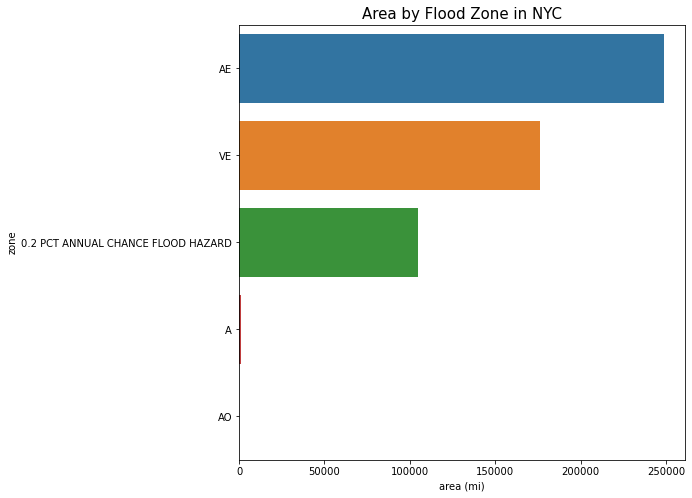

In [223]:
s1 = pd.Series(empty_dict).rename('area (mi)')
s1 = s1.reset_index().rename(columns={'index': 'zone'})
s1 = s1.sort_values(by='area (mi)', ascending=False)

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=s1, 
            x='area (mi)', 
            y='zone')

plt.title('Area by Flood Zone in NYC', fontsize=15)

In [224]:
pfirm_df.length.describe()

count      3448.000000
mean       4894.029117
std       14481.072675
min           0.463140
25%         636.531046
50%        1542.380217
75%        3811.199455
max      405938.650099
dtype: float64

In [225]:
pfirm_df.bounds.describe()

,minx,miny,maxx,maxy
count,3.448000e+03,3448.000000,3.448000e+03,3448.000000
mean,9.816710e+05,175493.674790,9.826482e+05,176524.173693
std,4.451364e+04,41795.734222,4.482823e+04,42094.317127
min,9.126579e+05,119624.665656,9.135851e+05,121022.589698
25%,9.354287e+05,138170.949348,9.358368e+05,139033.238060
50%,9.865366e+05,160207.244924,9.879018e+05,161841.804975
75%,1.022851e+06,219186.451195,1.023877e+06,220337.171334
max,1.060159e+06,270122.592022,1.060540e+06,273138.514468


In [226]:
pfirm_df.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry,wgs84
0,81,AE,None,T,13.0,NAVD88,NaN,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ...","POLYGON ((-73.82729 40.89080, -73.82728 40.890..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ...","POLYGON ((-73.82256 40.88991, -73.82252 40.889..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ...","POLYGON ((-73.82219 40.88747, -73.82219 40.887..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ...","POLYGON ((-73.81975 40.88694, -73.81975 40.886..."
5,86,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033316.808 262437.816, 1033316.108 ...","POLYGON ((-73.82255 40.88687, -73.82255 40.886..."


In [227]:
print('dataframe statistics\n')
print('number of rows: {:,}.\nnumber of columns: {}.'.format(pfirm_df.shape[0], pfirm_df.shape[1]))

dataframe statistics

number of rows: 3,448.
number of columns: 10.
